In [28]:
import os
import json
import pandas as pd
import numpy as np 
np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from scipy import stats

# Unzip NASLib/run/results/xgb_correlation.zip before running the code

In [29]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=0
END_SEED=4

def get_all_files(root_folder='../run/xgb_only_zc', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        # print(file_components)
        search_space, dataset, feature_size, train_size, seed = file_components[-6], file_components[-5], file_components[-4][2:], file_components[-3][len("train_size"):], file_components[-2][len("seed_"):]
        # ['..', 'run', 'xgb_only_zc', 'nasbench201', 'cifar10', 'k_3', 'train_size5', 'seed_9000', 'scores.json']
        with open(file, 'r') as f:
            info = json.load(f)

        config, scores = info[0], info[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'train_size': train_size,
            'feature size': feature_size,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        zc_names = config['zc_names']
        feature_importances = scores['zc_feature_importances']
        for zc_name in zc_names:
            record[f'{zc_name}_feat_imp'] = feature_importances[zc_name]

        data.append(record)

    return data

def plot_heatmap(df, figsize=(18, 6), rotation=0, title=''):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap='viridis')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation)
    
    
def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['train_size', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'train_size')
    pivot_df.columns = pivot_df.columns.astype(int)
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    print('PIVOT TABLE')
    print(pivot_df)
    print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['train_size'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['train_size'] == zc_2]['preds'].to_list()[0])
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        train_sizes = tuple(df_['train_size'].to_list()) # List of predictor names

        all_corrs.append(compute_correlation(df_, train_sizes))

    corr = np.mean(np.array(all_corrs), axis=0)
    corr_df = pd.DataFrame(corr)

    train_sizes_map = {i: train_sizes[i] for i in range(len(train_sizes))}
    corr_df = corr_df.rename(columns=train_sizes_map, index=train_sizes_map)
    plot_heatmap(corr_df, title=f'ZC Correlation for {search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'train_size'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_train_size_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'train_size'])[metric].mean()
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s, left_index=True, right_index=True)

    return idf

# with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
#     data = json.load(f)


In [30]:
files = get_all_files()

In [31]:
df = make_df(files)
print(df)
# print(min([int(chars) for chars in df['feature size'].tolist()]))

3


In [83]:
def get_metrics(df, search_space, dataset, train_size, metric):
    print(search_space, train_size, dataset)
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == str(train_size)) & (df['dataset'] == dataset)]

    # print(df_)
    # print(df_[metric])
    # print(type())
    return df_[metric]  # removed tolist() because I don't have multiple predictor sizes)

def get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric):
    results = []

    for train_size in train_sizes:
        res = get_metrics(df, search_space, dataset, train_size, metric)
        if len(res) > 0:
            results.append(res)
    # print(results)
    # print(len(results))
    # print([len(results[i]) for i in range(len(results))])
    results = np.array(results)
    means = np.mean(results, axis=1)
    stds = np.std(results, axis=1)
    
    return means, stds

def plot_line_chart(x_labels, means, stds, color, title='', ylabel='', use_same_fig=False, legend=None):
    if not use_same_fig:
        figsize=(16, 8)
        plt.figure(figsize=figsize, dpi=200)
        plt.title(title, fontsize=20)
    plt.plot(x_labels, means, color=color, label=legend)
    plt.fill_between(x_labels, means + stds, means - stds, color=color, alpha=0.2)
    plt.xscale('log', base=10)
    plt.xlabel('Train size')
    plt.ylabel(ylabel)
    # if legend:
    #     plt.legend(legend)


def plot_train_sizes_vs_metric(df, search_space, dataset, train_sizes, metric, color='gray'):
    means, stds = get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric)
    # print(means, stds)
    plot_line_chart(train_sizes, means, stds, color, title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient')

def plot_feature_train_sizes_vs_metric(df, search_space, dataset, train_sizes, feature_sizes, metric, colors=('red', 'blue', 'gray', 'black')):
    for i, feature_size in enumerate(feature_sizes):
        sub_df = df[(df['feature size'] == str(feature_size))]
        means, stds = get_metrics_as_np_arrays(sub_df, search_space, dataset, train_sizes, metric)
        # print(means, stds)
        plot_line_chart(train_sizes, means, stds, colors[i], title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient', use_same_fig=(i!=0), legend='feaures='+feature_size)
    plt.legend(loc="lower right")



nasbench201 5 cifar10
nasbench201 8 cifar10
nasbench201 14 cifar10
nasbench201 24 cifar10
nasbench201 42 cifar10
nasbench201 71 cifar10
nasbench201 121 cifar10
nasbench201 5 cifar10
nasbench201 8 cifar10
nasbench201 14 cifar10
nasbench201 24 cifar10
nasbench201 42 cifar10
nasbench201 71 cifar10
nasbench201 121 cifar10


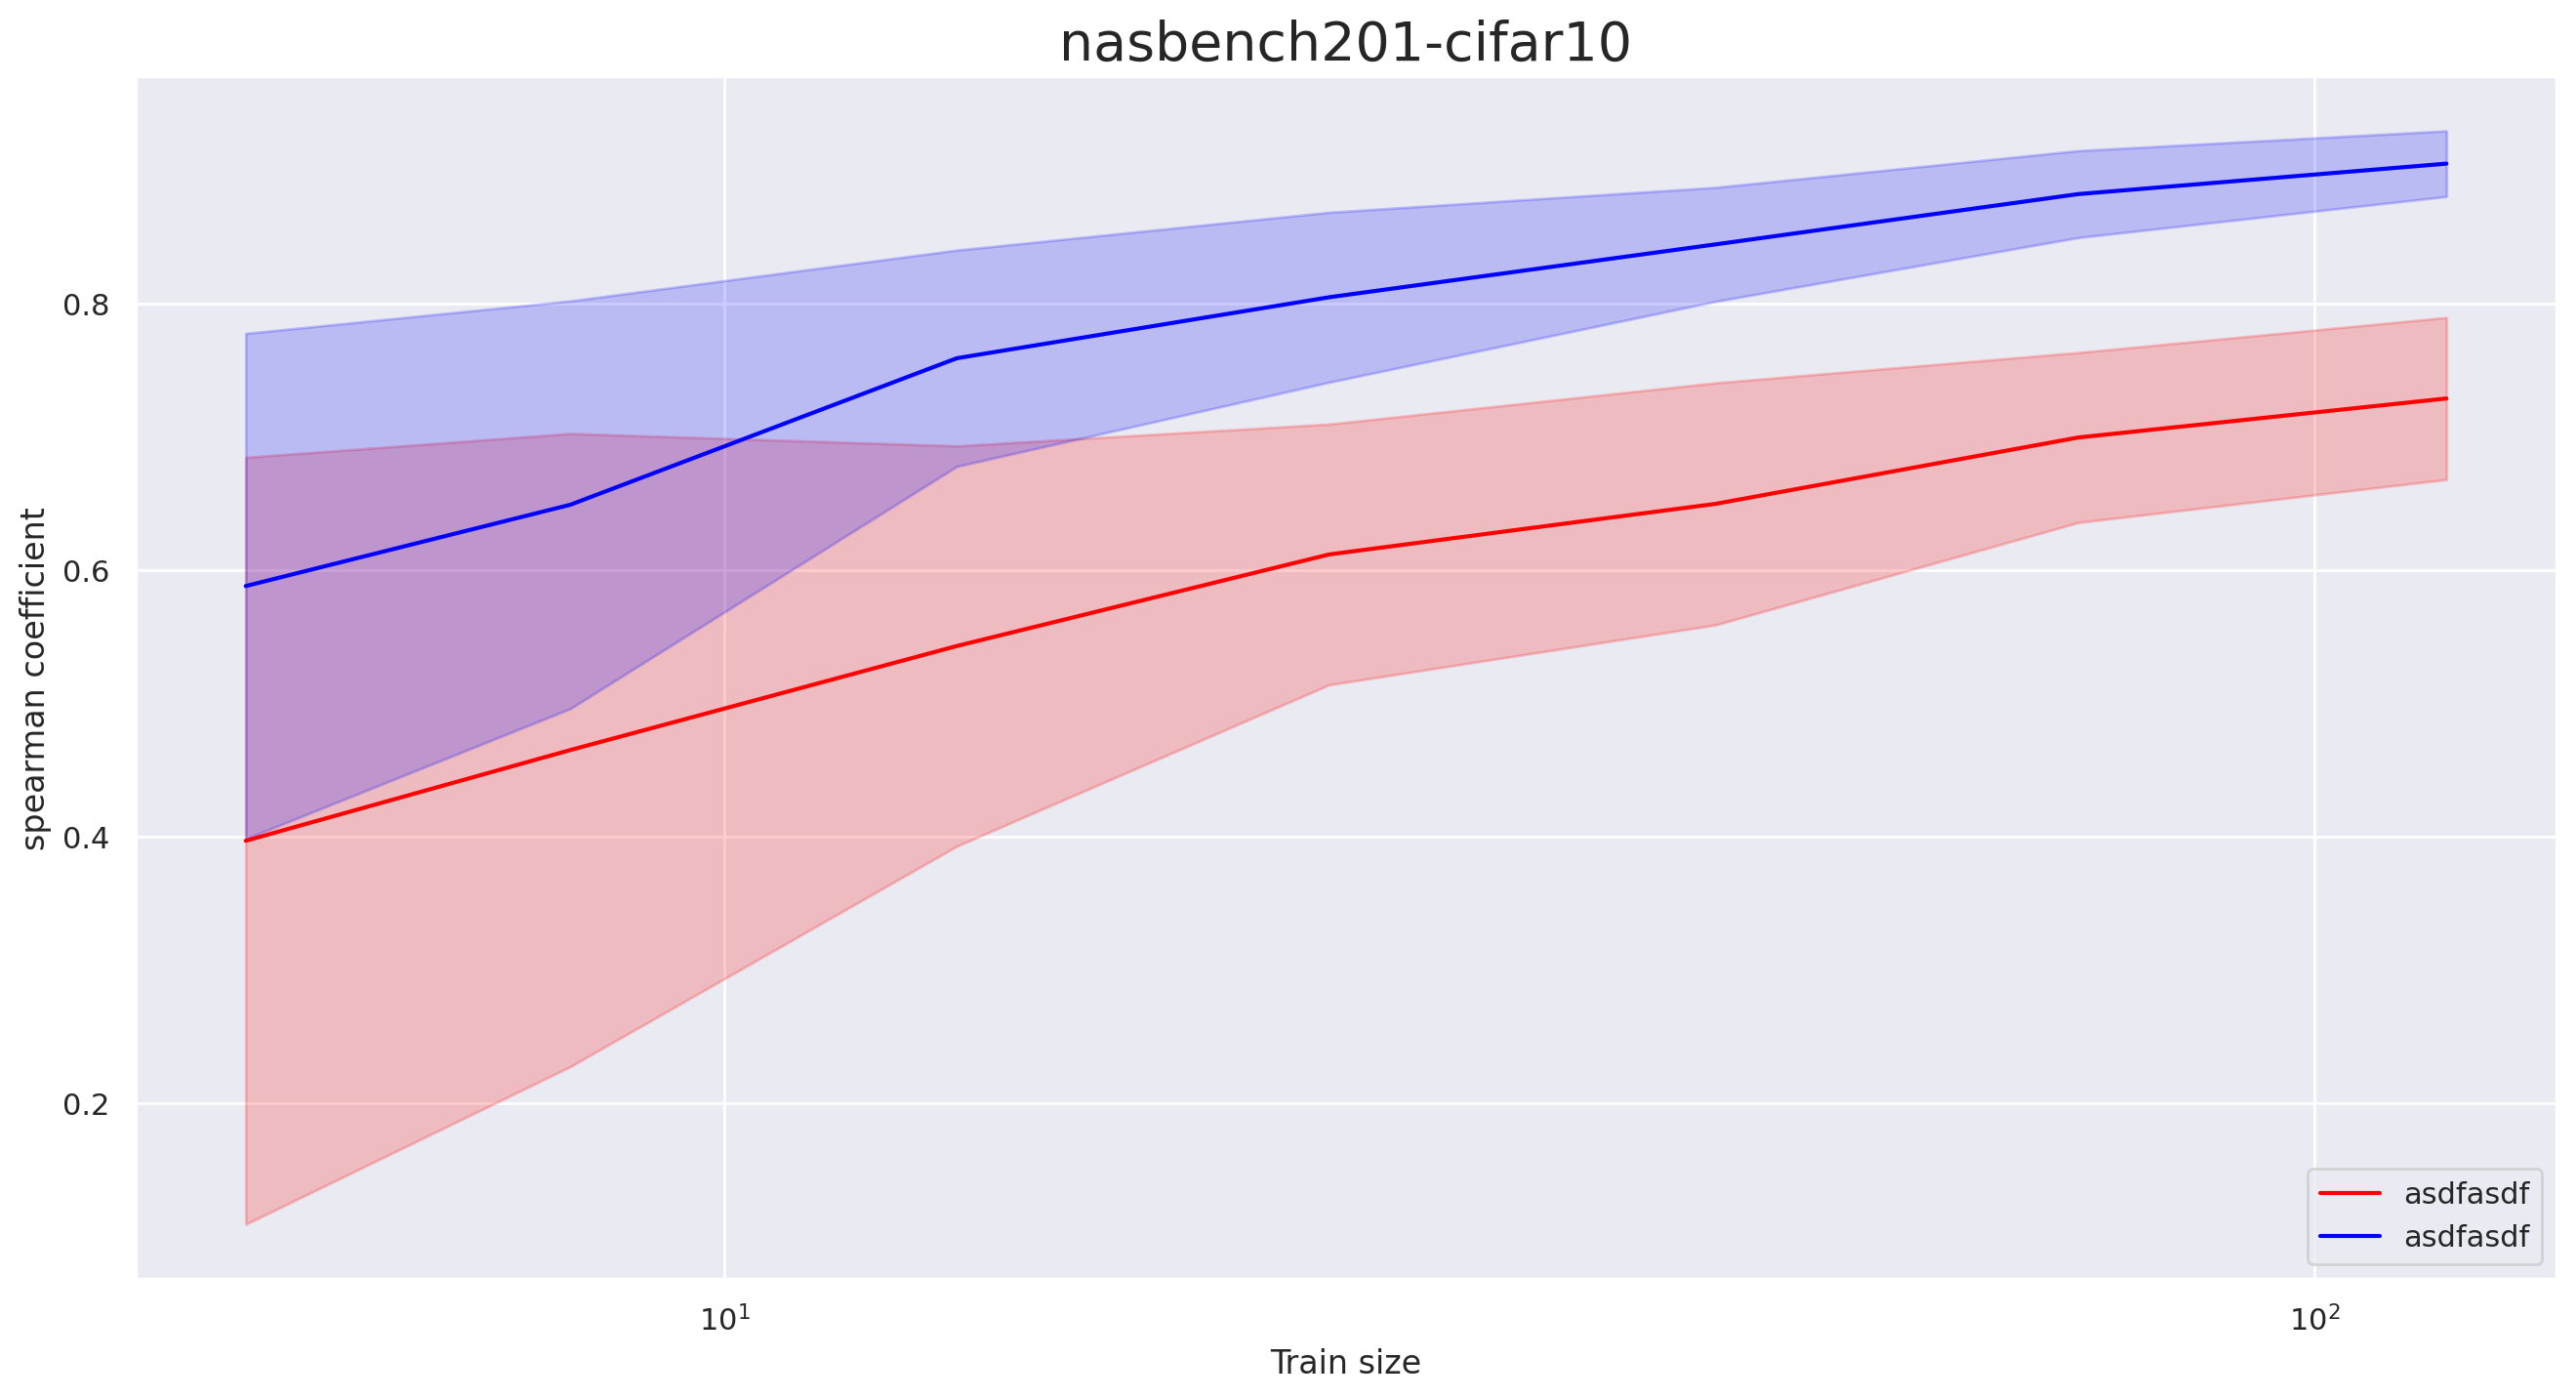

In [84]:
# train_sizes = [10, 16, 27, 46, 77, 129, 215, 359, 599]
# train_sizes = [10, 15, 23, 36, 56, 87, 135, 209, 323, 500]
# train_sizes = [400]
train_sizes = (5, 8, 14, 24, 42, 71, 121) #, 205, 347, 589, 1000)

#df = make_df(files)
# sp = get_metrics(df, 'nasbench201', 'cifar10', 5, 'spearman')
three_features = df[(df['feature size'] == '3')]
thirteen_features = df[(df['feature size'] == '13')]
feature_sizes=['3', '13']
plot_feature_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes, feature_sizes, 'spearman')

# plot_train_sizes_vs_metric(three_features, 'nasbench201', 'cifar10', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(thirteen_features, 'nasbench201', 'cifar10', train_sizes, 'spearman', color='grey')


# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'kendalltau', color='green')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'kendalltau', color='blue')

In [85]:
def get_mean_grouped_by(df, search_space, dataset, train_size):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == train_size) & (df['dataset'] == dataset)]
    return df_.groupby(['search_space', 'dataset', 'train_size'], as_index=False).mean()

def get_averaged_df(df, search_space, train_sizes):
    dfs = []

    for dataset in BENCHMARKS[search_space]:
        for train_size in train_sizes:
            dfs.append(get_mean_grouped_by(df, search_space, dataset, str(train_size)))
    
    return pd.concat(dfs)

def get_feature_importance_df(df, search_space, train_size):
    avg_df = get_averaged_df(df, search_space, train_sizes)
    feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
    avg_df = avg_df[avg_df['train_size'] == train_size].set_index('dataset')[feat_imp_cols]
    return avg_df

def plot_feature_importance_heatmap(df, search_space, train_size):
    avg_df = get_feature_importance_df(df, search_space, str(train_size))
    
    if search_space == 'transbench101_micro' or search_space == 'transbench101_macro':
        avg_df = avg_df.drop(columns=['epe_nas_feat_imp', 'synflow_feat_imp'])
    plot_heatmap(avg_df, rotation=45, title=f'{search_space}. Train size: {train_size}')

In [86]:
avg_df_nb201 = get_averaged_df(df, 'nasbench201', train_sizes)
avg_df_nb301 = get_averaged_df(df, 'nasbench301', train_sizes)
avg_df_tnb_micro = get_averaged_df(df, 'transbench101_micro', train_sizes)
avg_df_tnb_macro = get_averaged_df(df, 'transbench101_macro', train_sizes)
avg_df = pd.concat([avg_df_nb201, avg_df_nb301, avg_df_tnb_micro, avg_df_tnb_macro], axis=0)
avg_df

,search_space,dataset,train_size,kendalltau,pearson,spearman,synflow_feat_imp,flops_feat_imp,params_feat_imp,plain_feat_imp,l2_norm_feat_imp,snip_feat_imp,grad_norm_feat_imp,nwot_feat_imp,zen_feat_imp,fisher_feat_imp,jacov_feat_imp,epe_nas_feat_imp,grasp_feat_imp
0,nasbench201,cifar10,5,0.374893,0.406117,0.492326,9.80,62.23,0.00,1.08,1.32,0.00,0.68,0.00,0.10,13.12,3.12,99.24,1.32
0,nasbench201,cifar10,8,0.411484,0.445276,0.556849,26.90,86.89,0.00,4.20,4.40,1.36,1.54,0.92,0.90,20.54,6.74,101.72,4.28
0,nasbench201,cifar10,14,0.480869,0.513400,0.650818,66.82,123.40,0.02,10.26,7.66,0.66,4.10,5.22,4.82,26.24,16.74,93.90,9.06
0,nasbench201,cifar10,24,0.530284,0.662245,0.708016,118.38,145.25,0.43,17.14,16.42,2.60,5.38,12.02,11.02,29.16,27.86,107.14,12.40
0,nasbench201,cifar10,42,0.566370,0.786093,0.746829,208.84,185.90,2.14,27.24,21.56,5.24,12.94,19.56,21.36,40.60,42.70,107.80,20.98
0,nasbench201,cifar10,71,0.613311,0.839642,0.790556,346.63,264.79,4.70,42.82,30.12,12.48,23.04,24.52,31.50,54.58,53.16,119.22,35.30
0,nasbench201,cifar10,121,0.643347,0.888400,0.816612,613.40,377.72,9.74,62.64,51.76,26.46,40.96,40.72,48.46,84.76,78.12,150.78,58.50
0,nasbench201,cifar100,5,0.344619,0.373747,0.446698,17.16,116.54,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,nasbench201,cifar100,8,0.355447,0.402497,0.484784,56.16,158.74,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,nasbench201,cifar100,14,0.415131,0.463480,0.575232,129.56,218.40,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
feat_imp_cols

['synflow_feat_imp',
 'flops_feat_imp',
 'params_feat_imp',
 'plain_feat_imp',
 'l2_norm_feat_imp',
 'snip_feat_imp',
 'grad_norm_feat_imp',
 'nwot_feat_imp',
 'zen_feat_imp',
 'fisher_feat_imp',
 'jacov_feat_imp',
 'epe_nas_feat_imp',
 'grasp_feat_imp']

In [88]:
df = make_df(files)

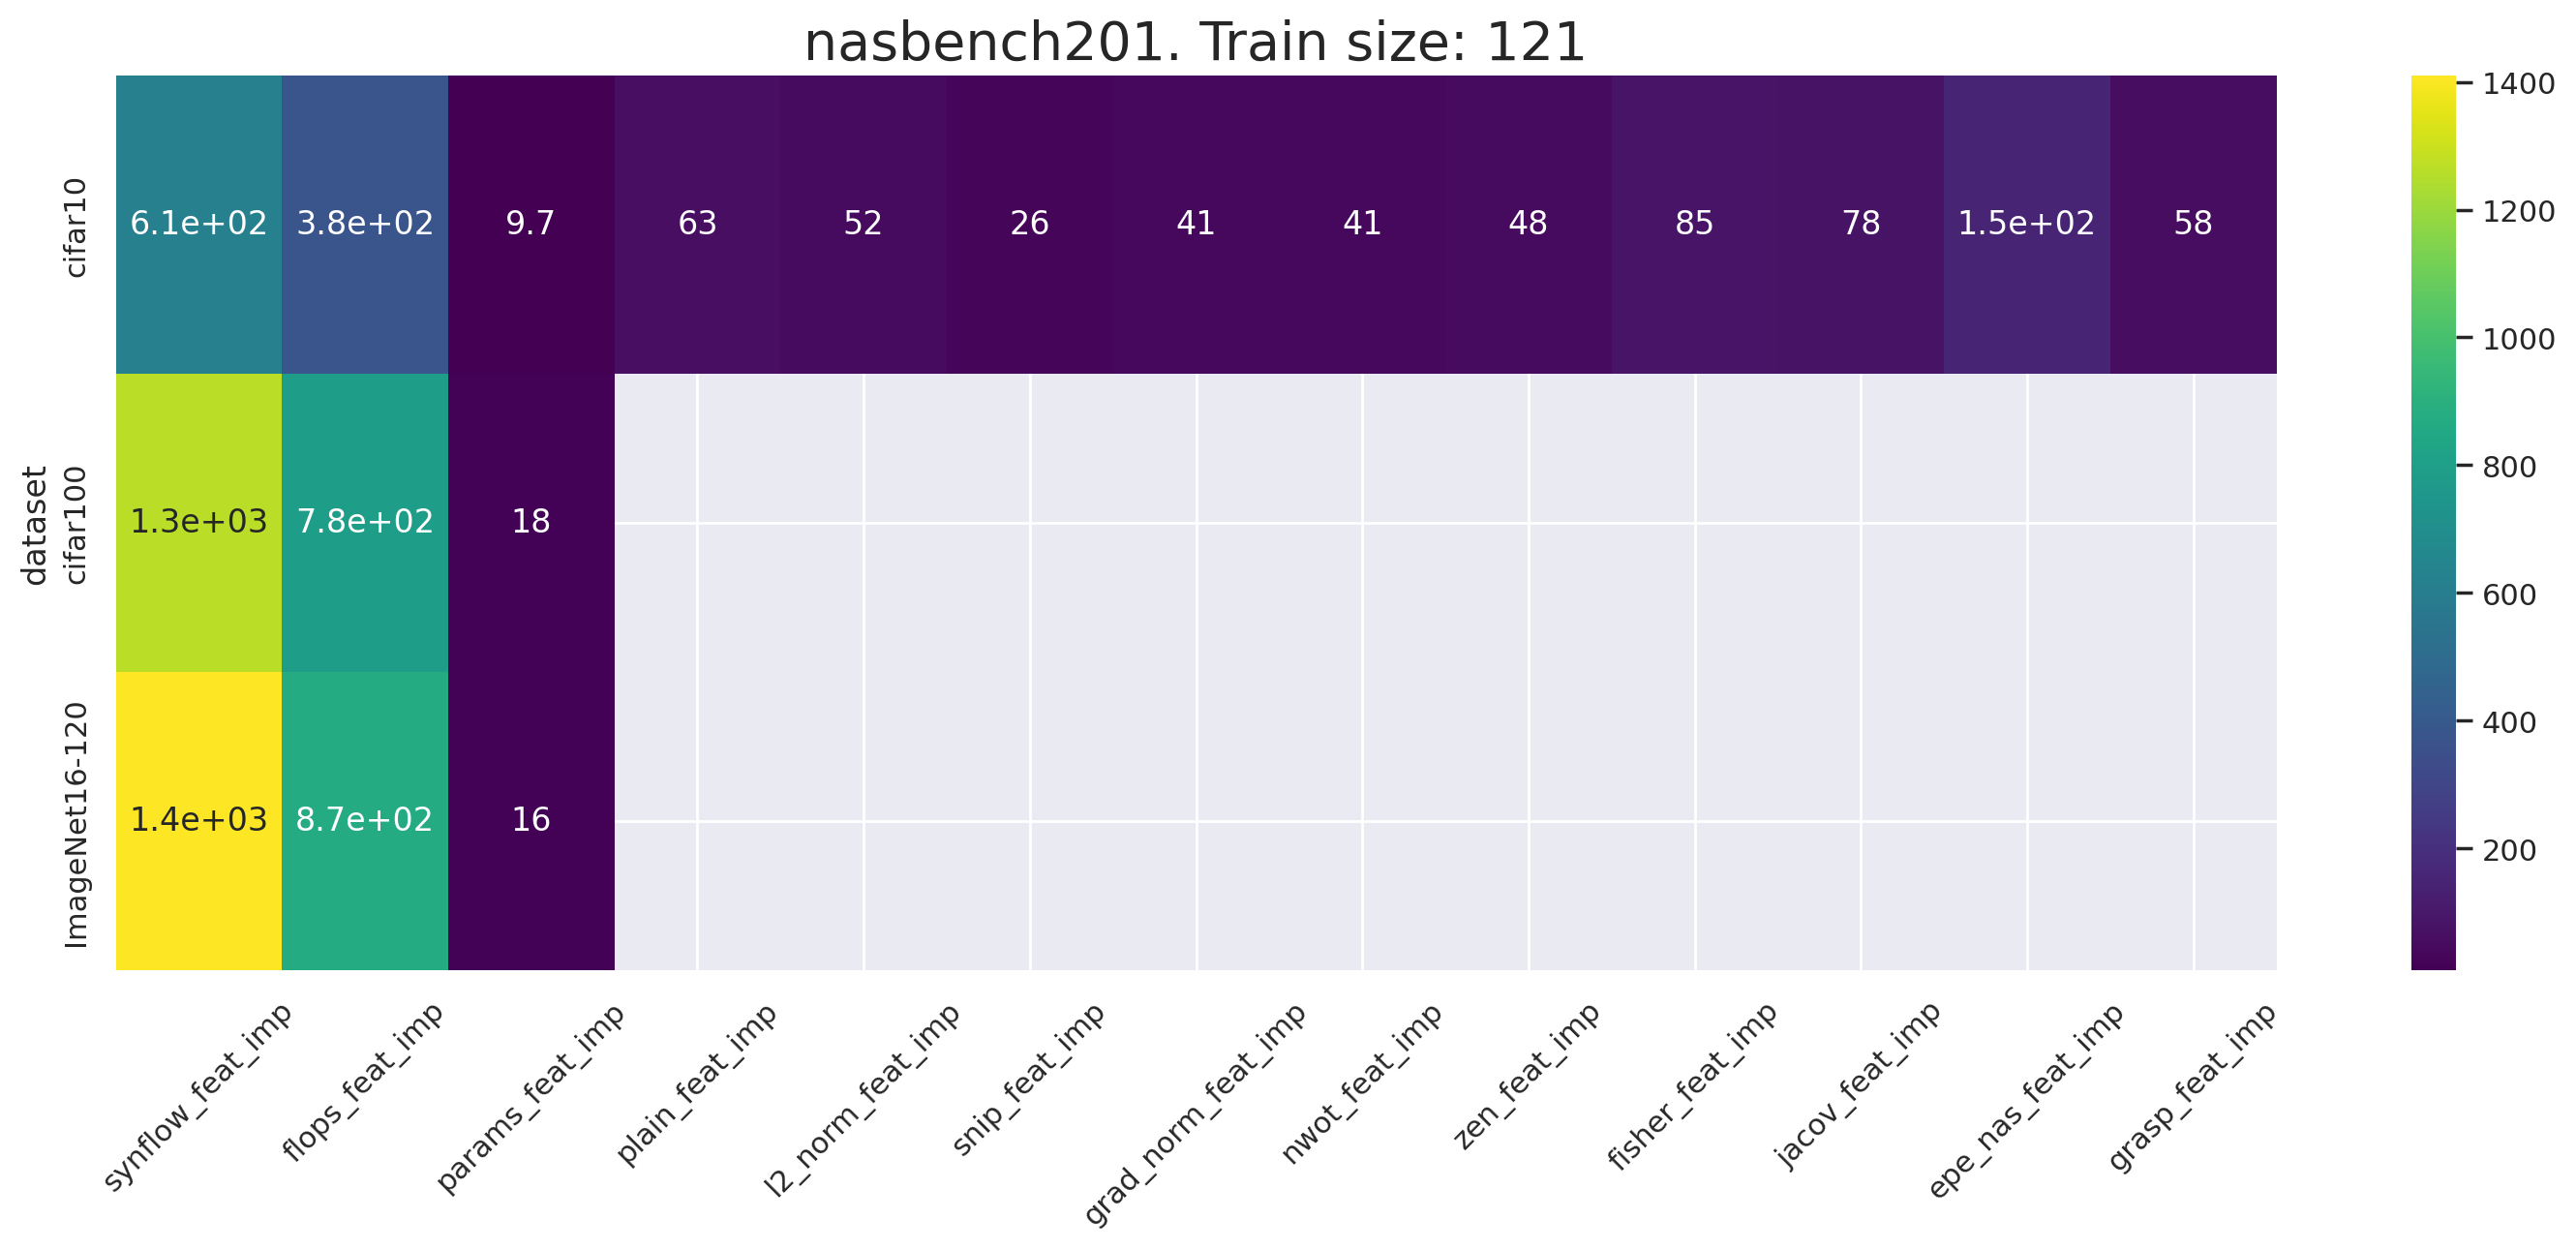

In [89]:
search_space='nasbench201'
train_size=121
plot_feature_importance_heatmap(df, search_space, train_size=train_size)

ValueError: zero-size array to reduction operation fmin which has no identity

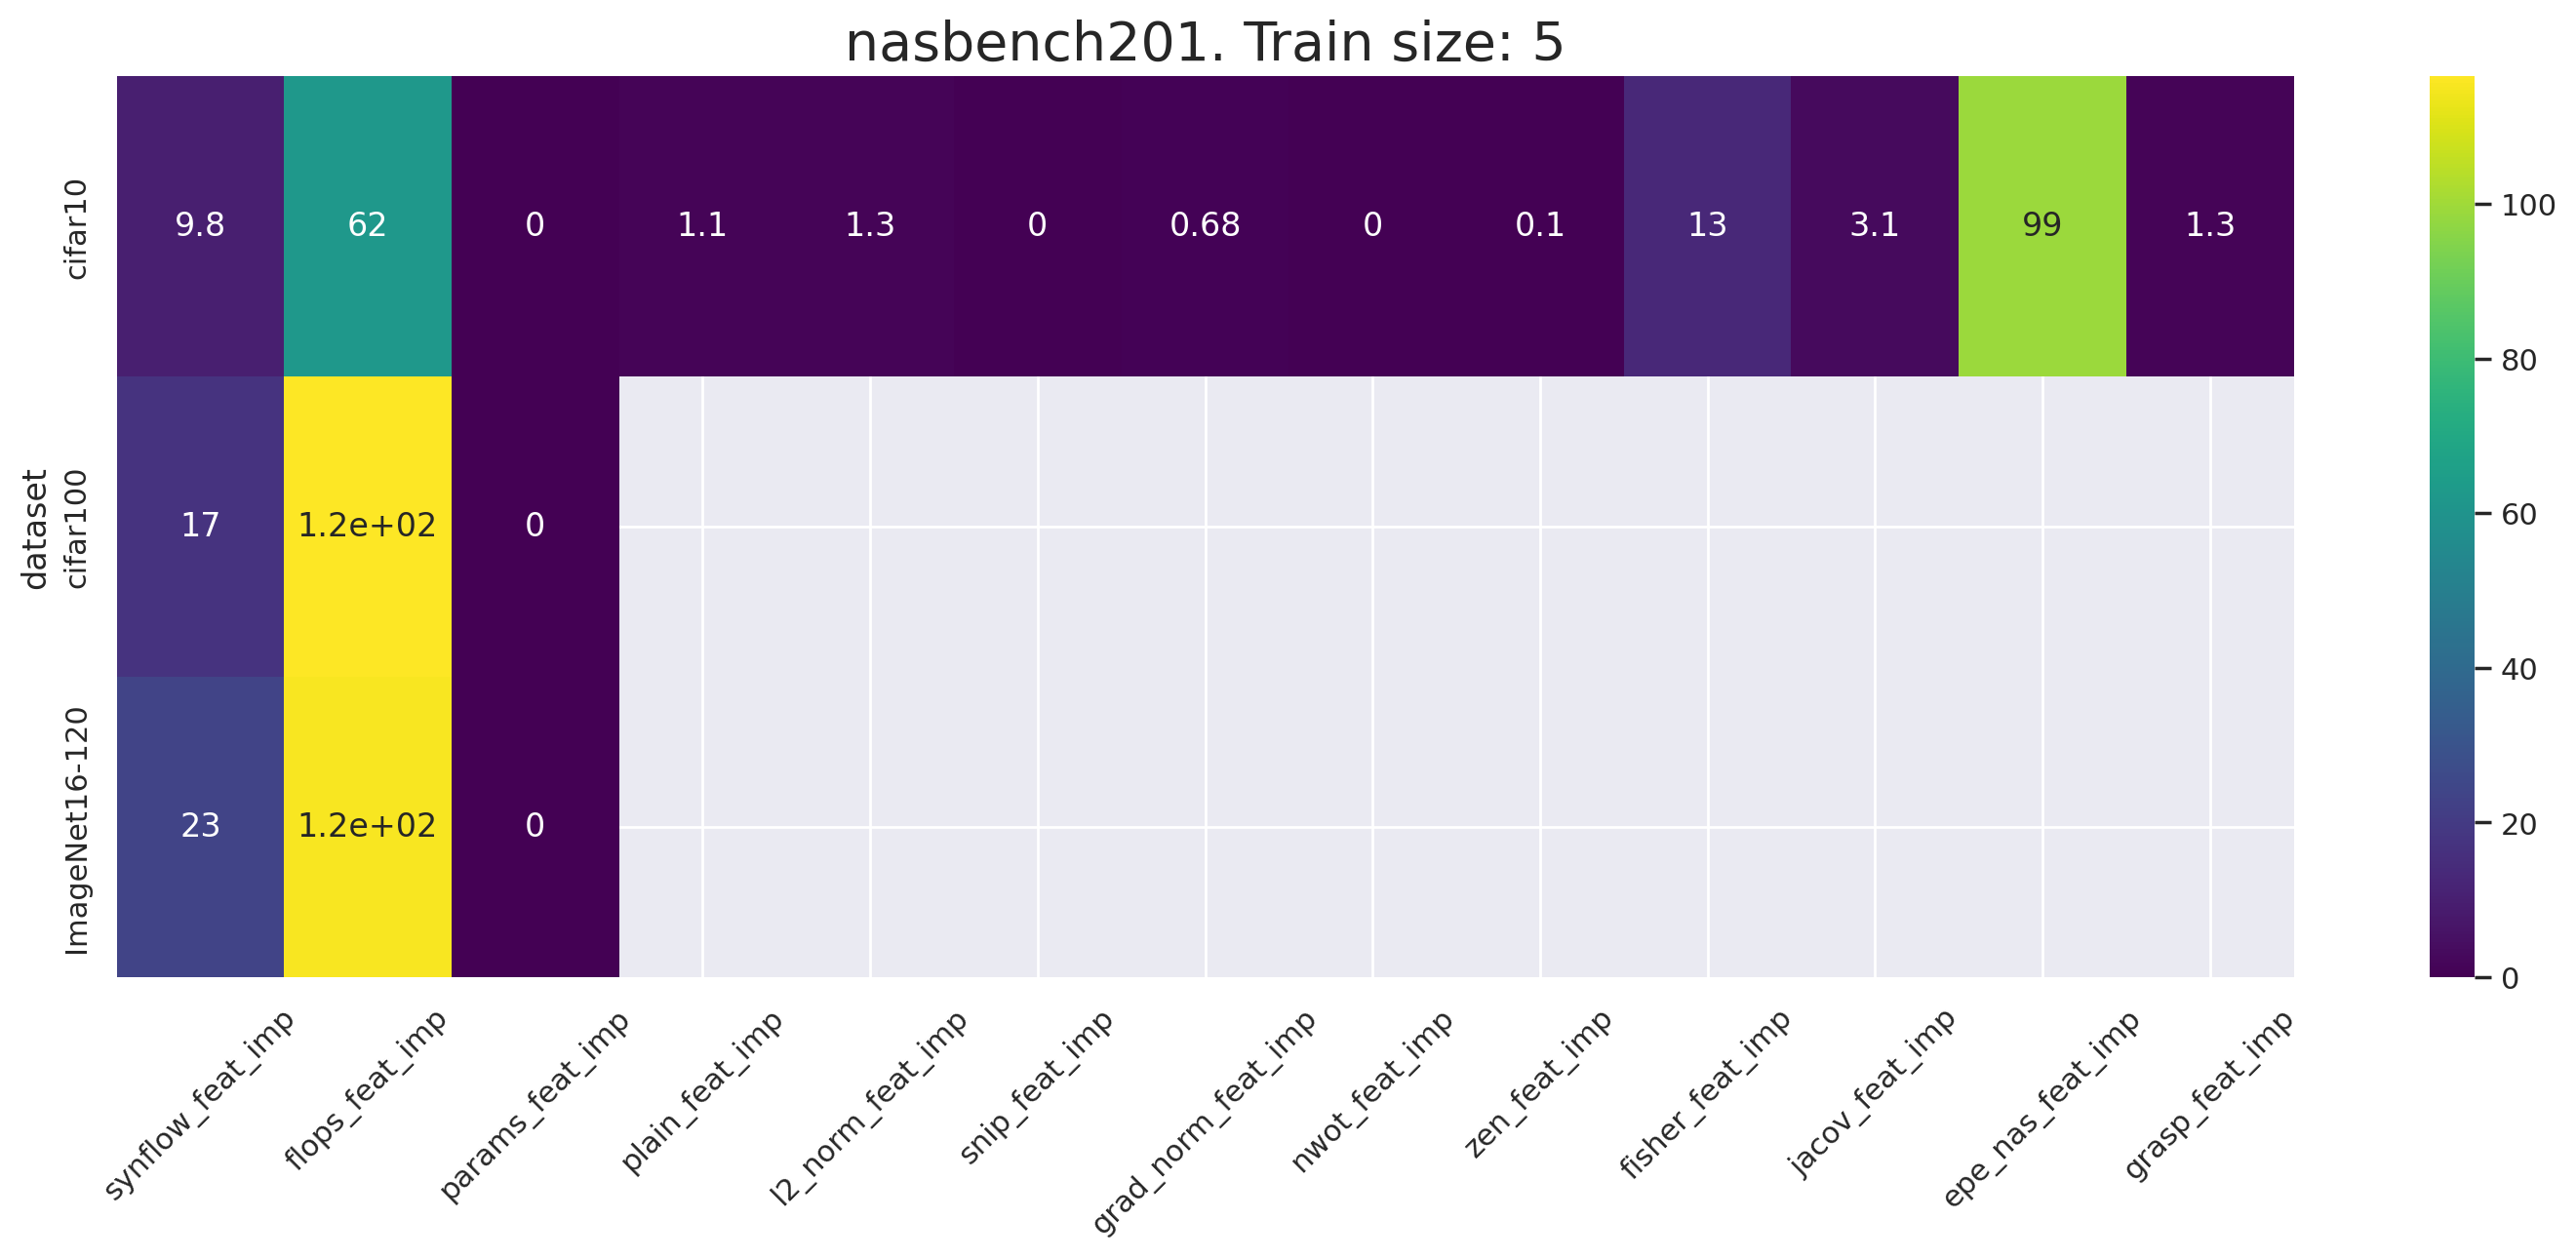

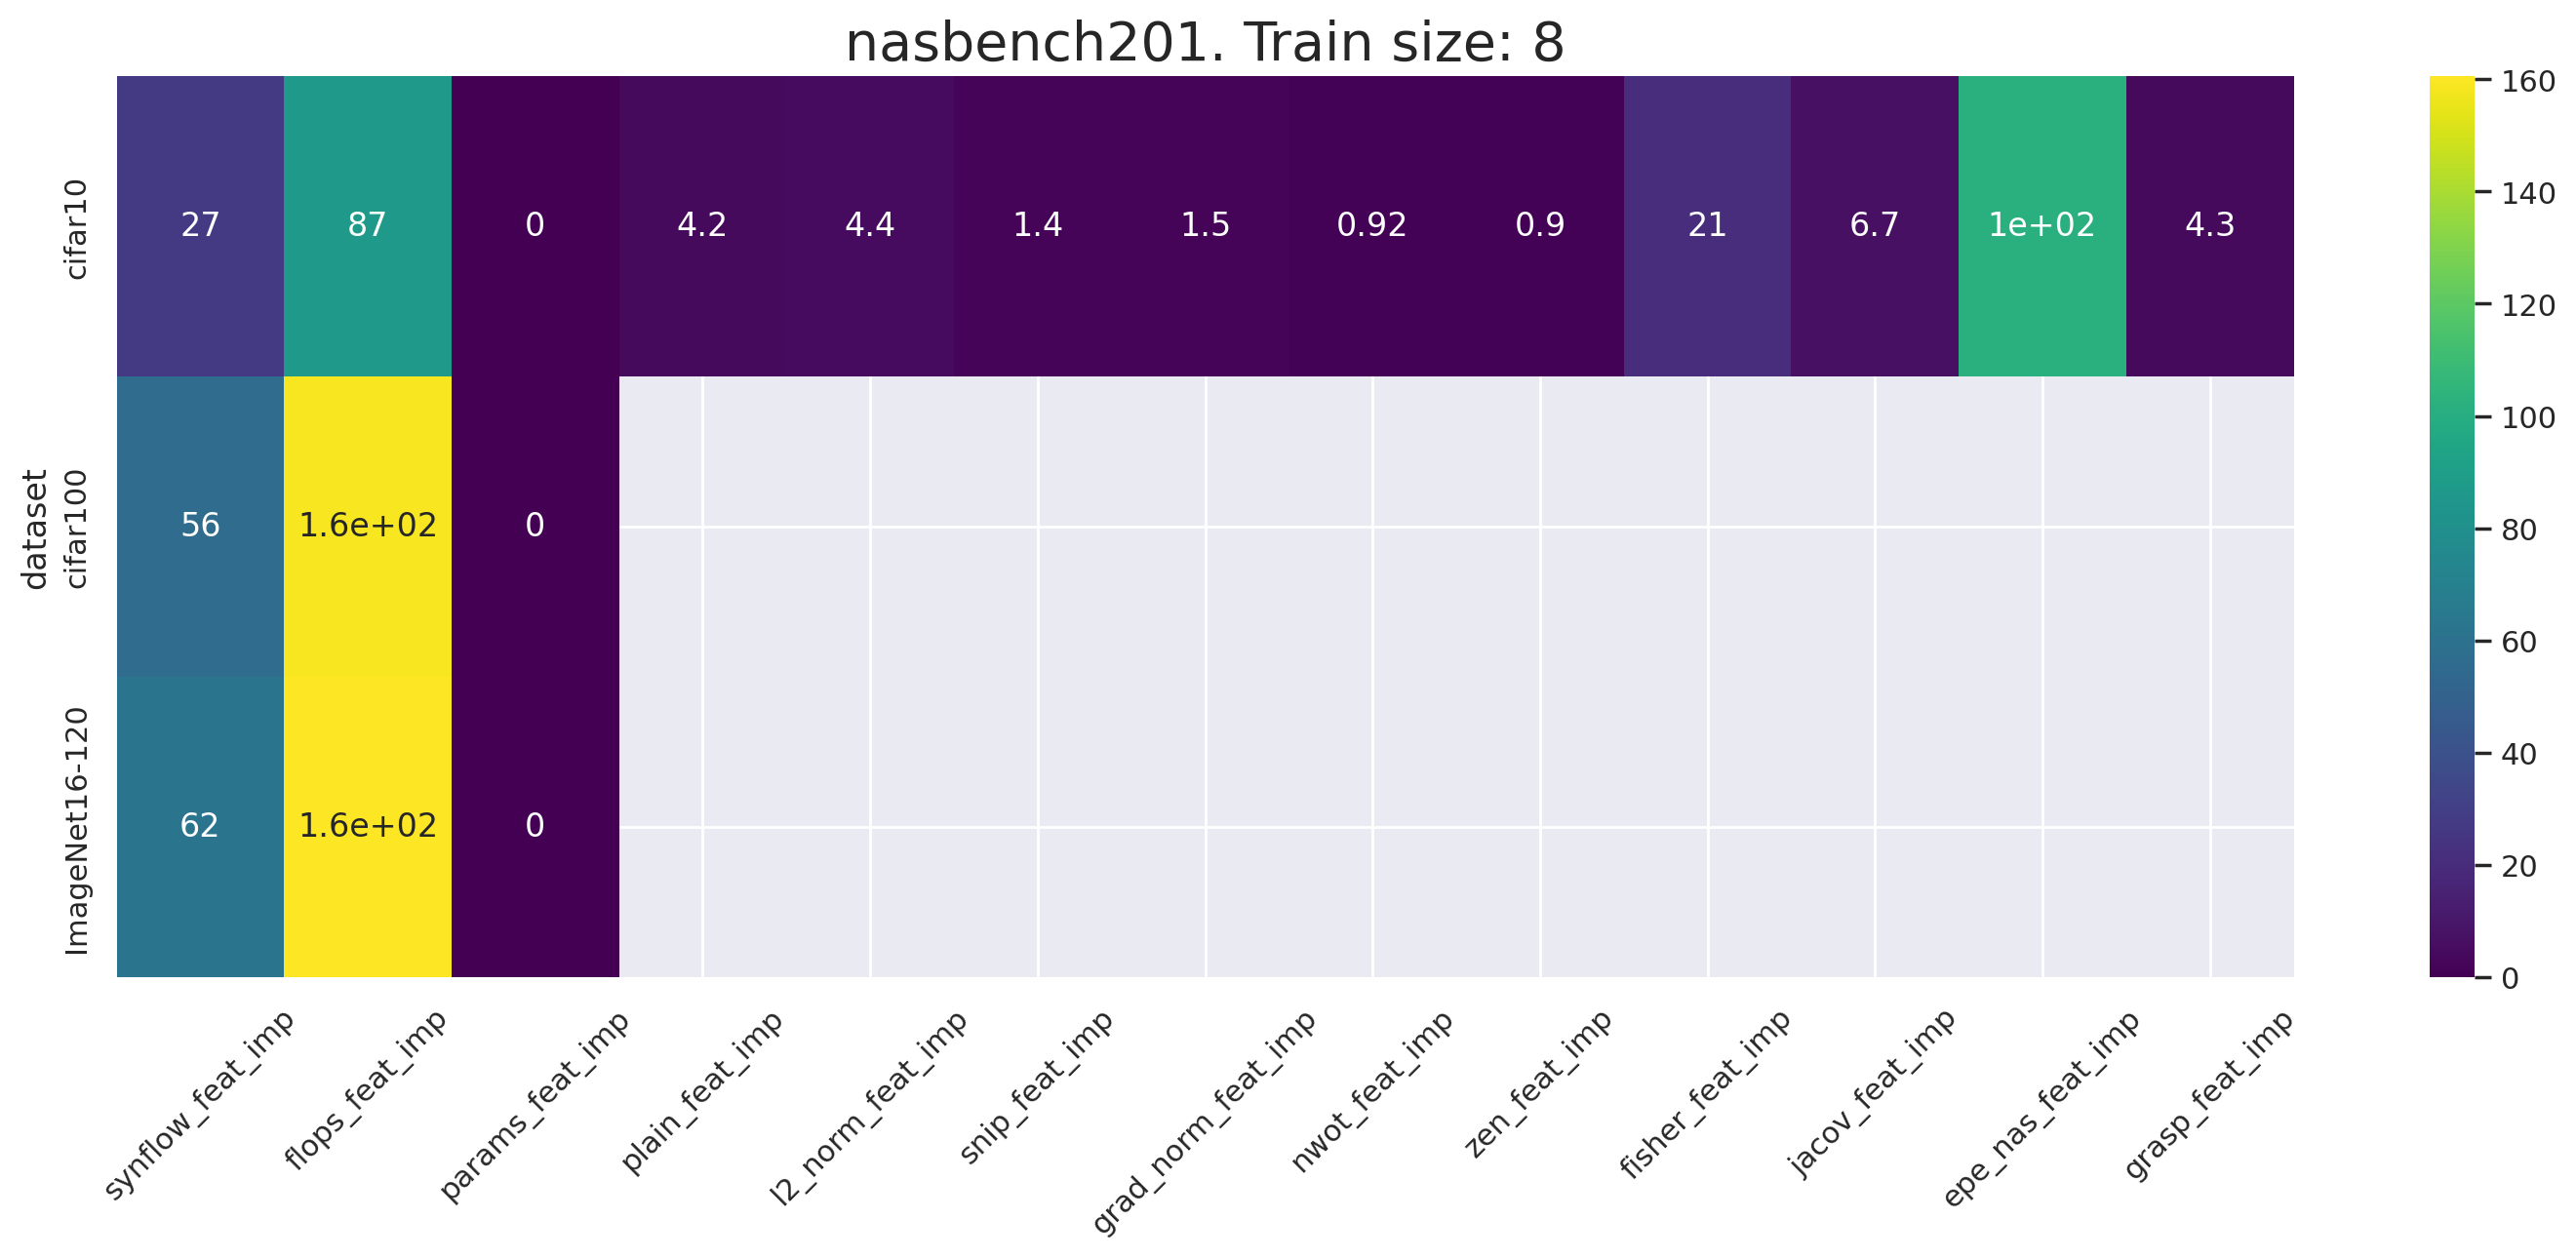

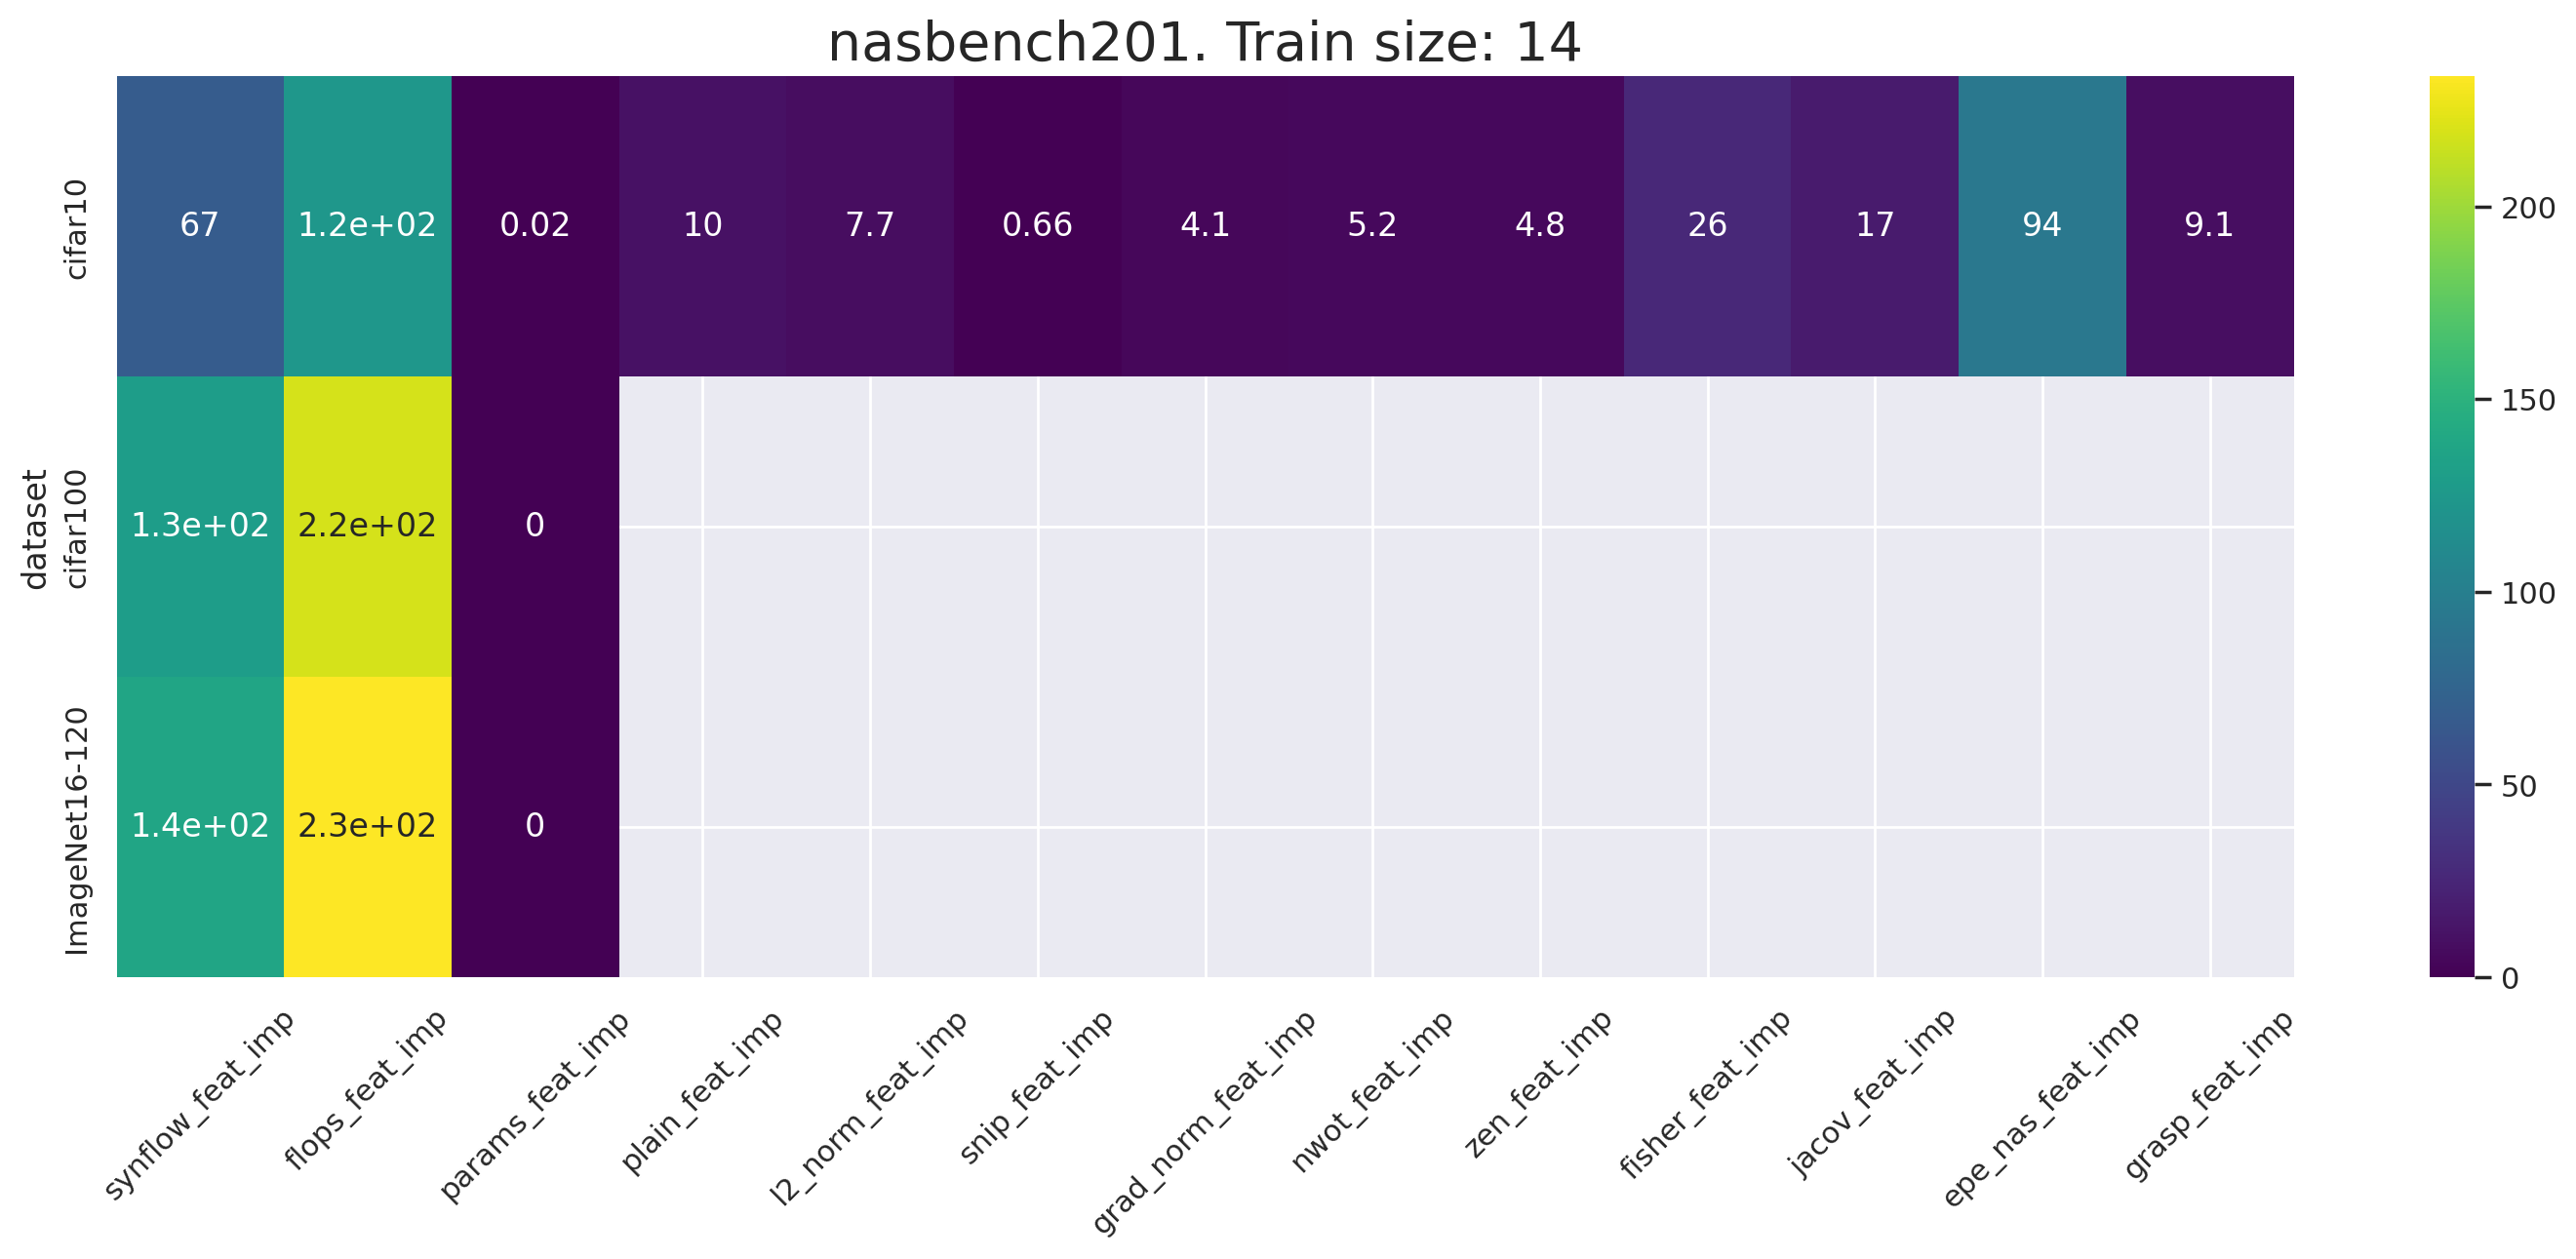

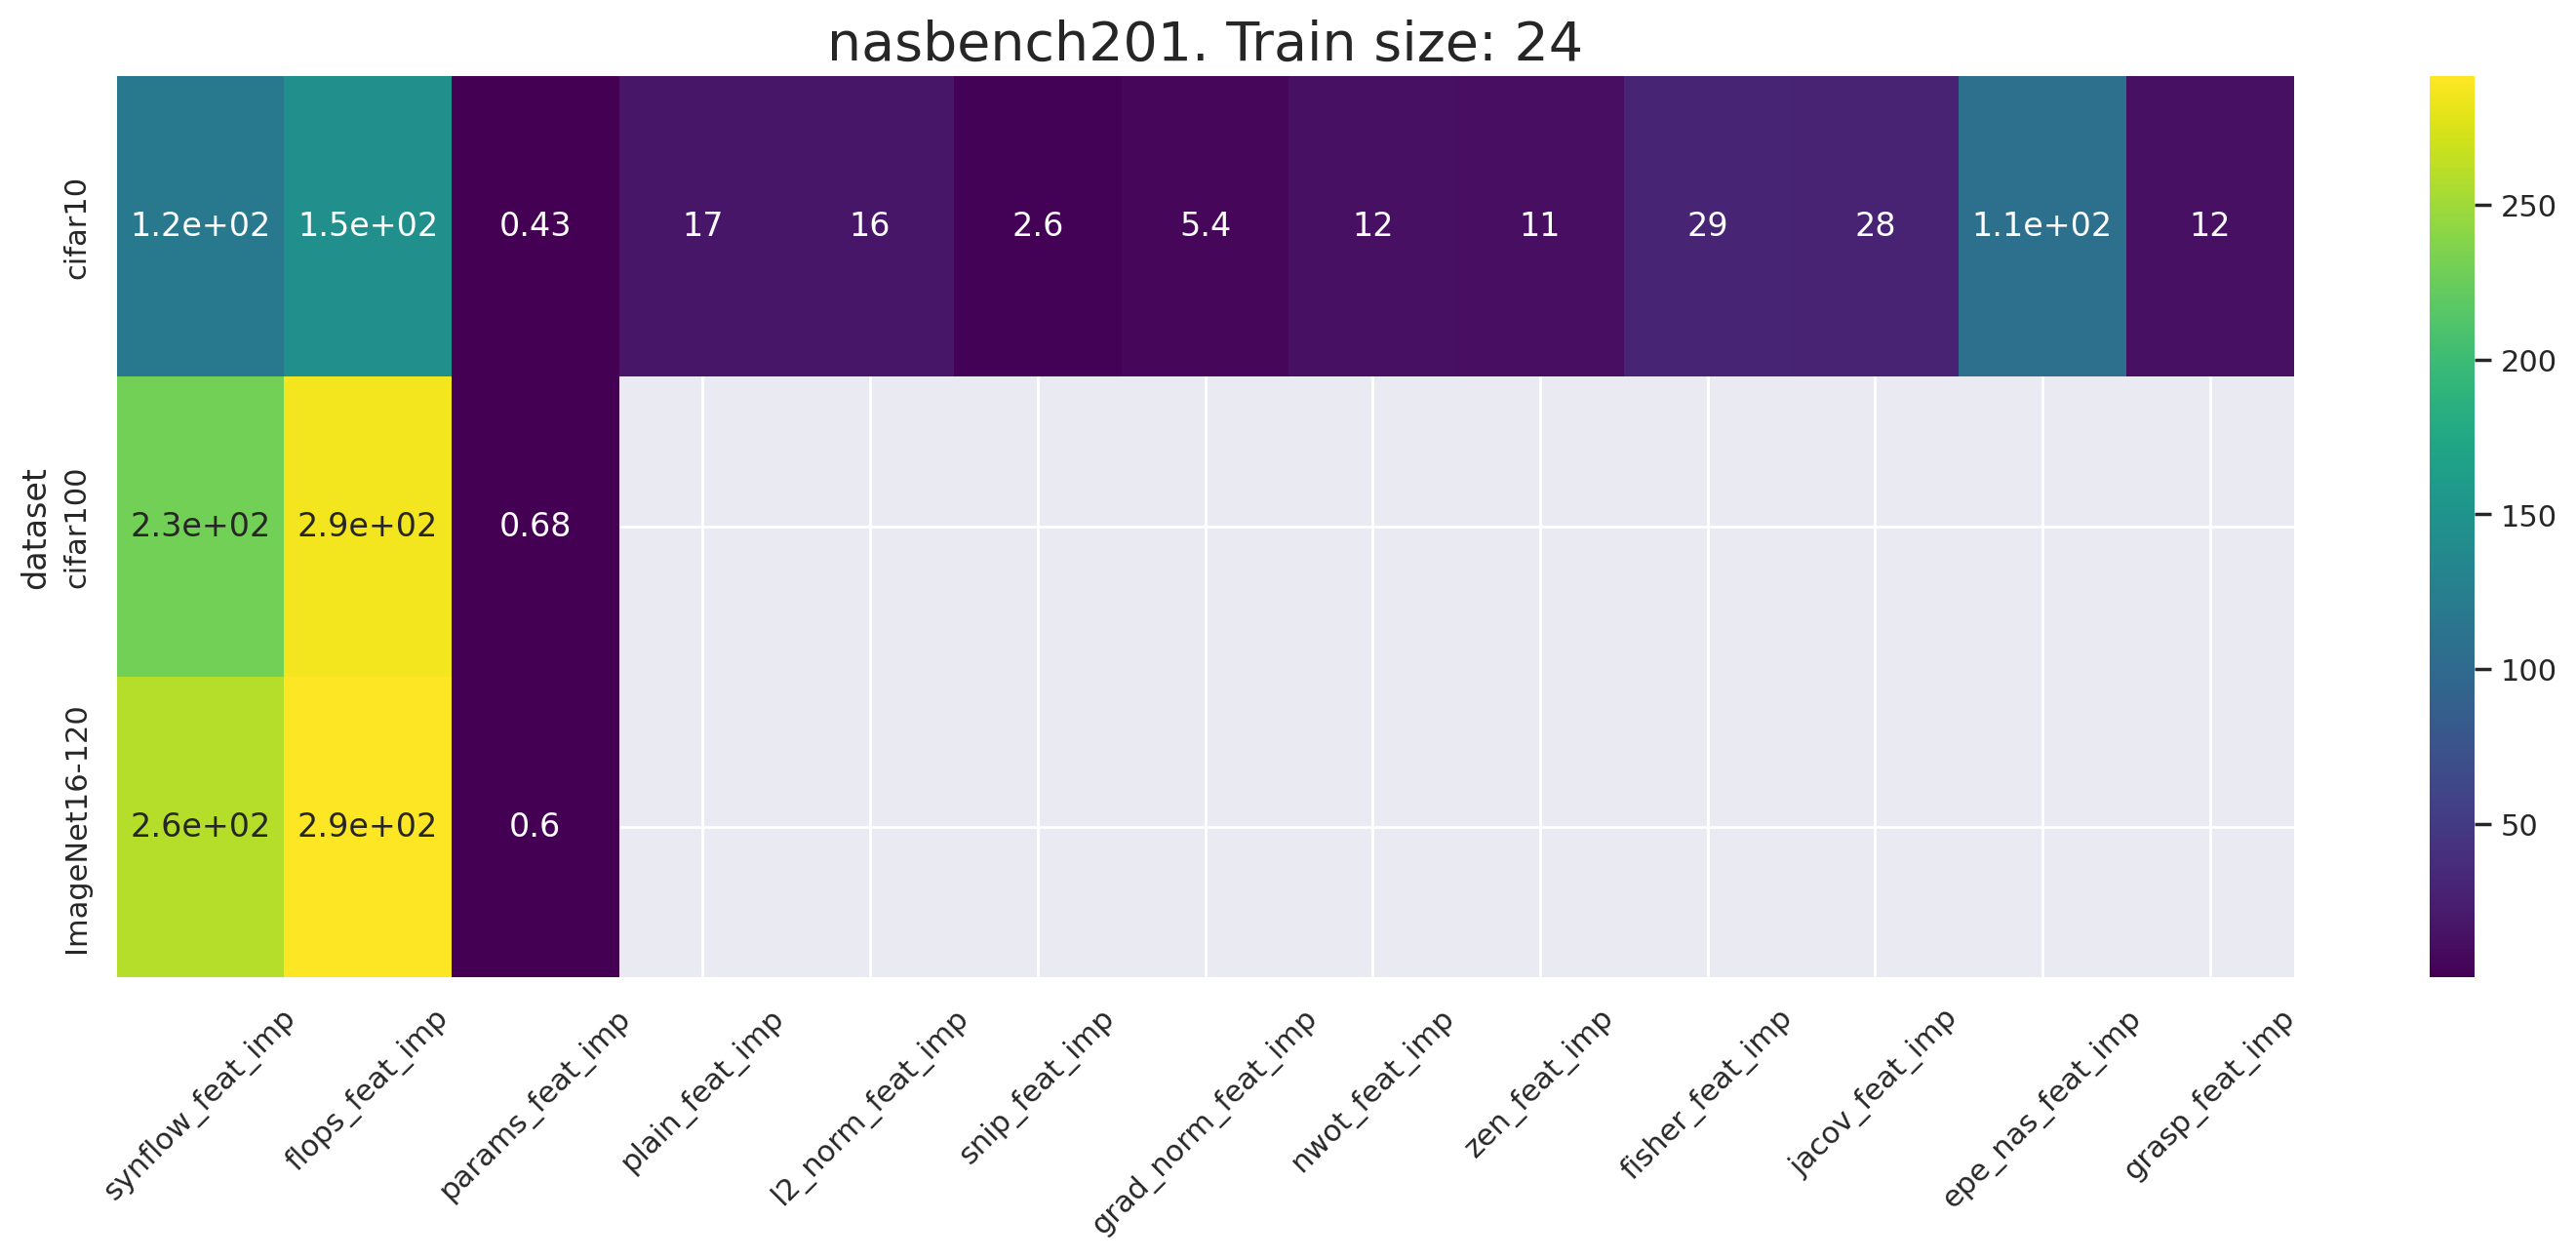

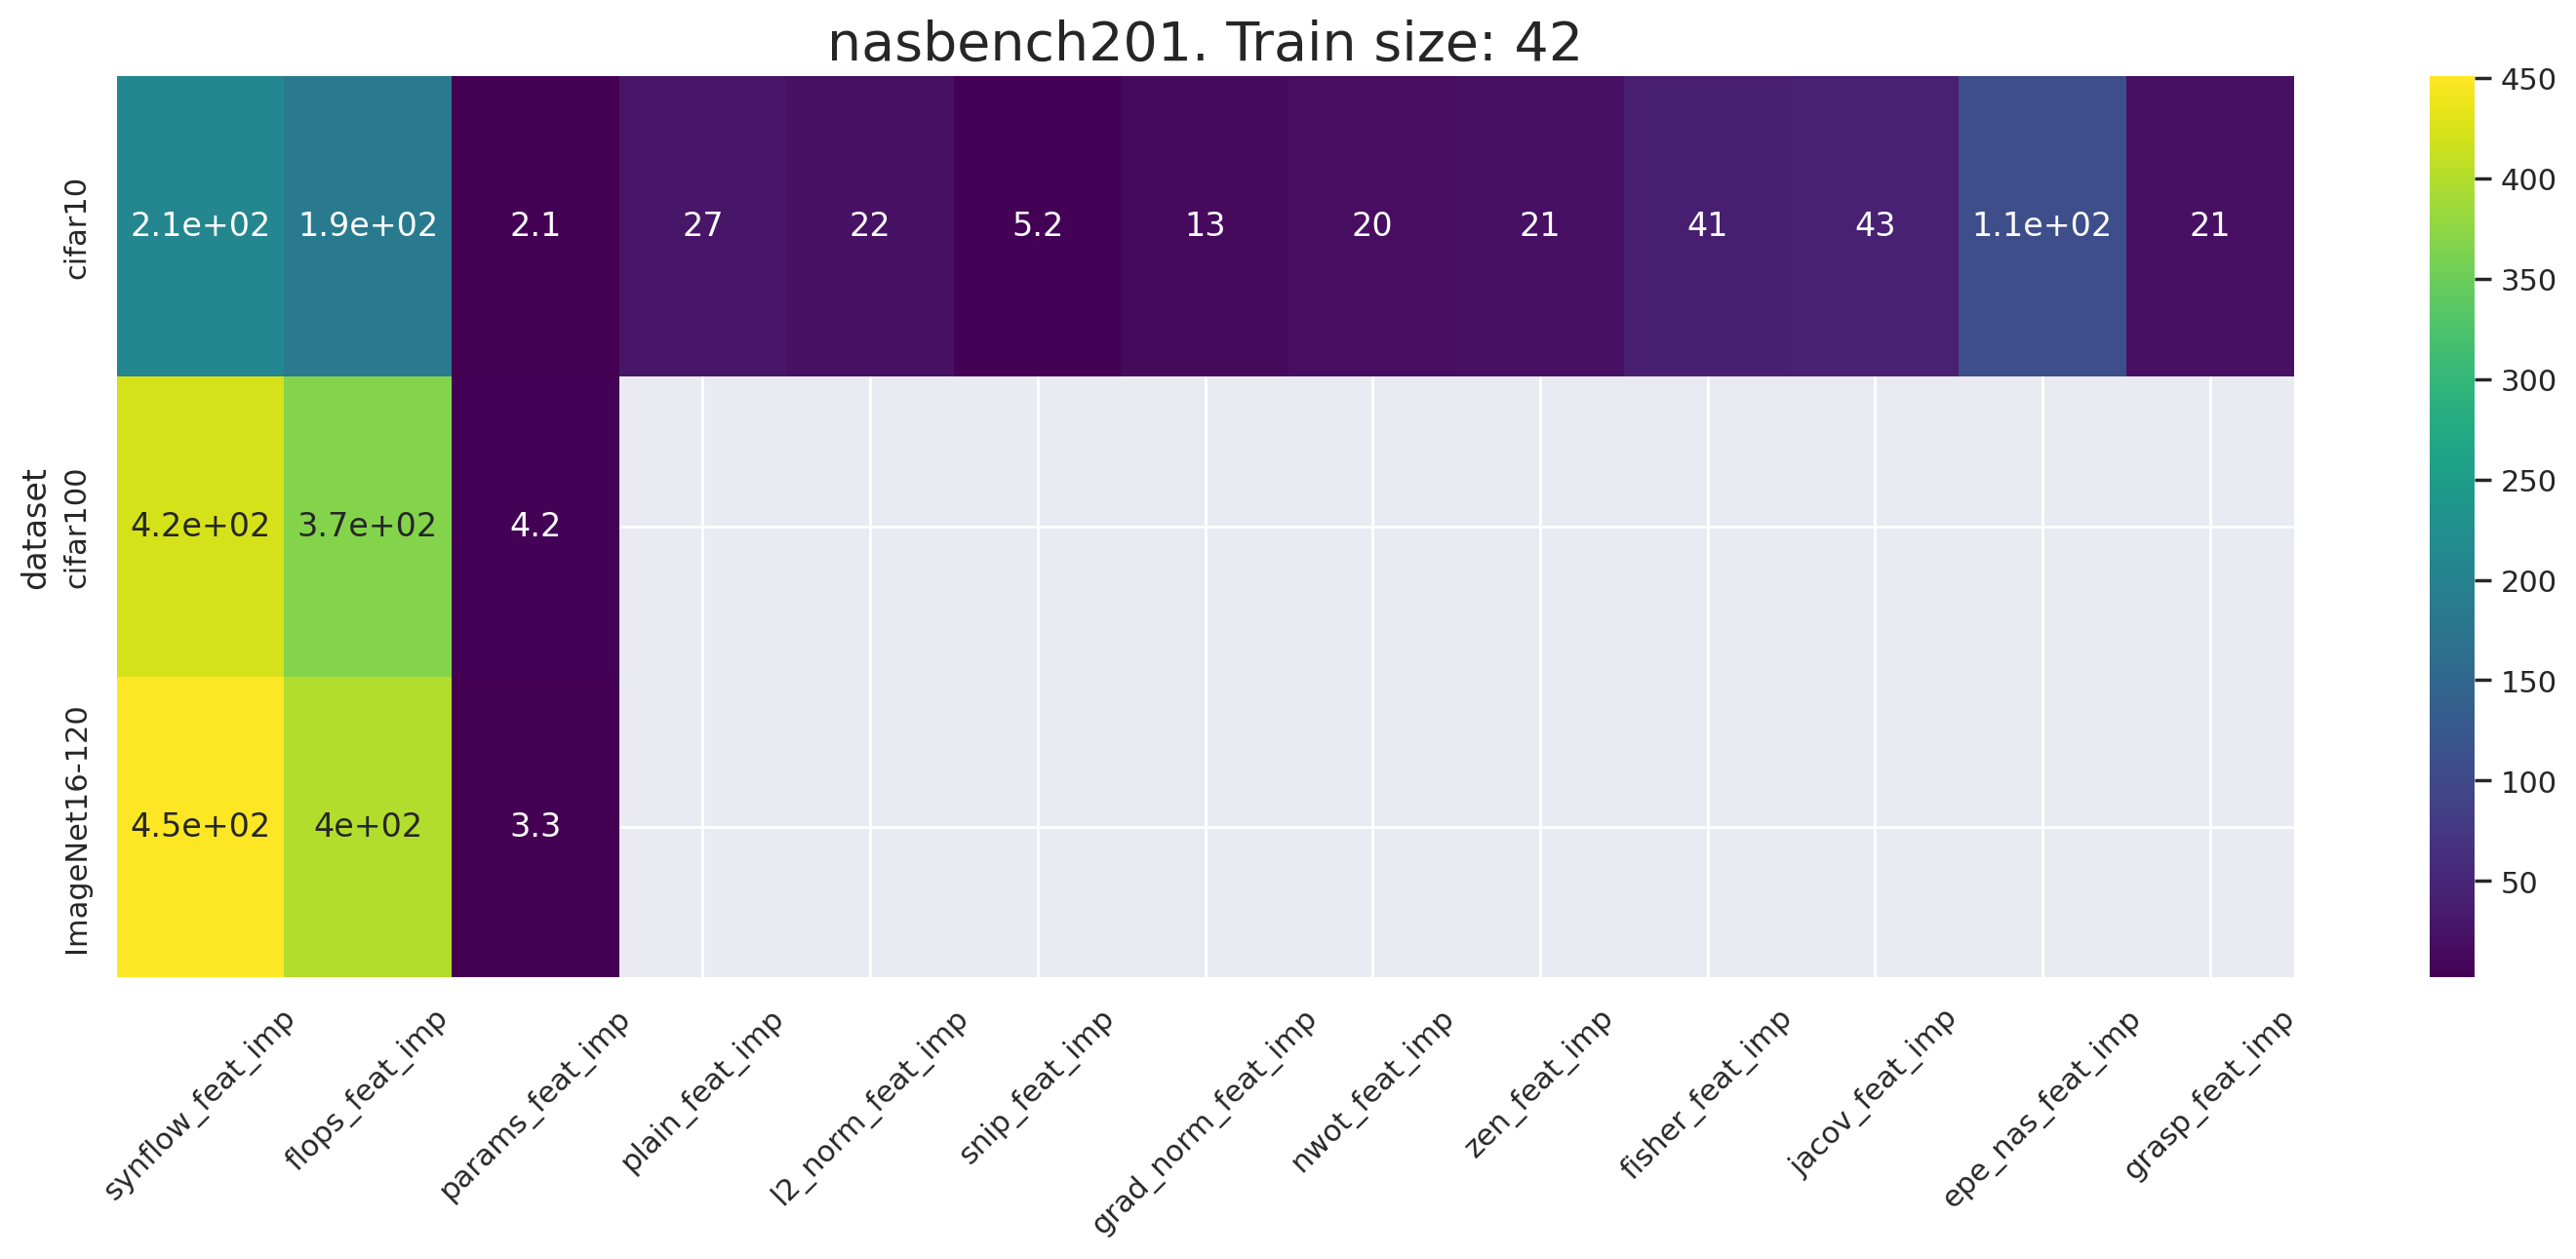

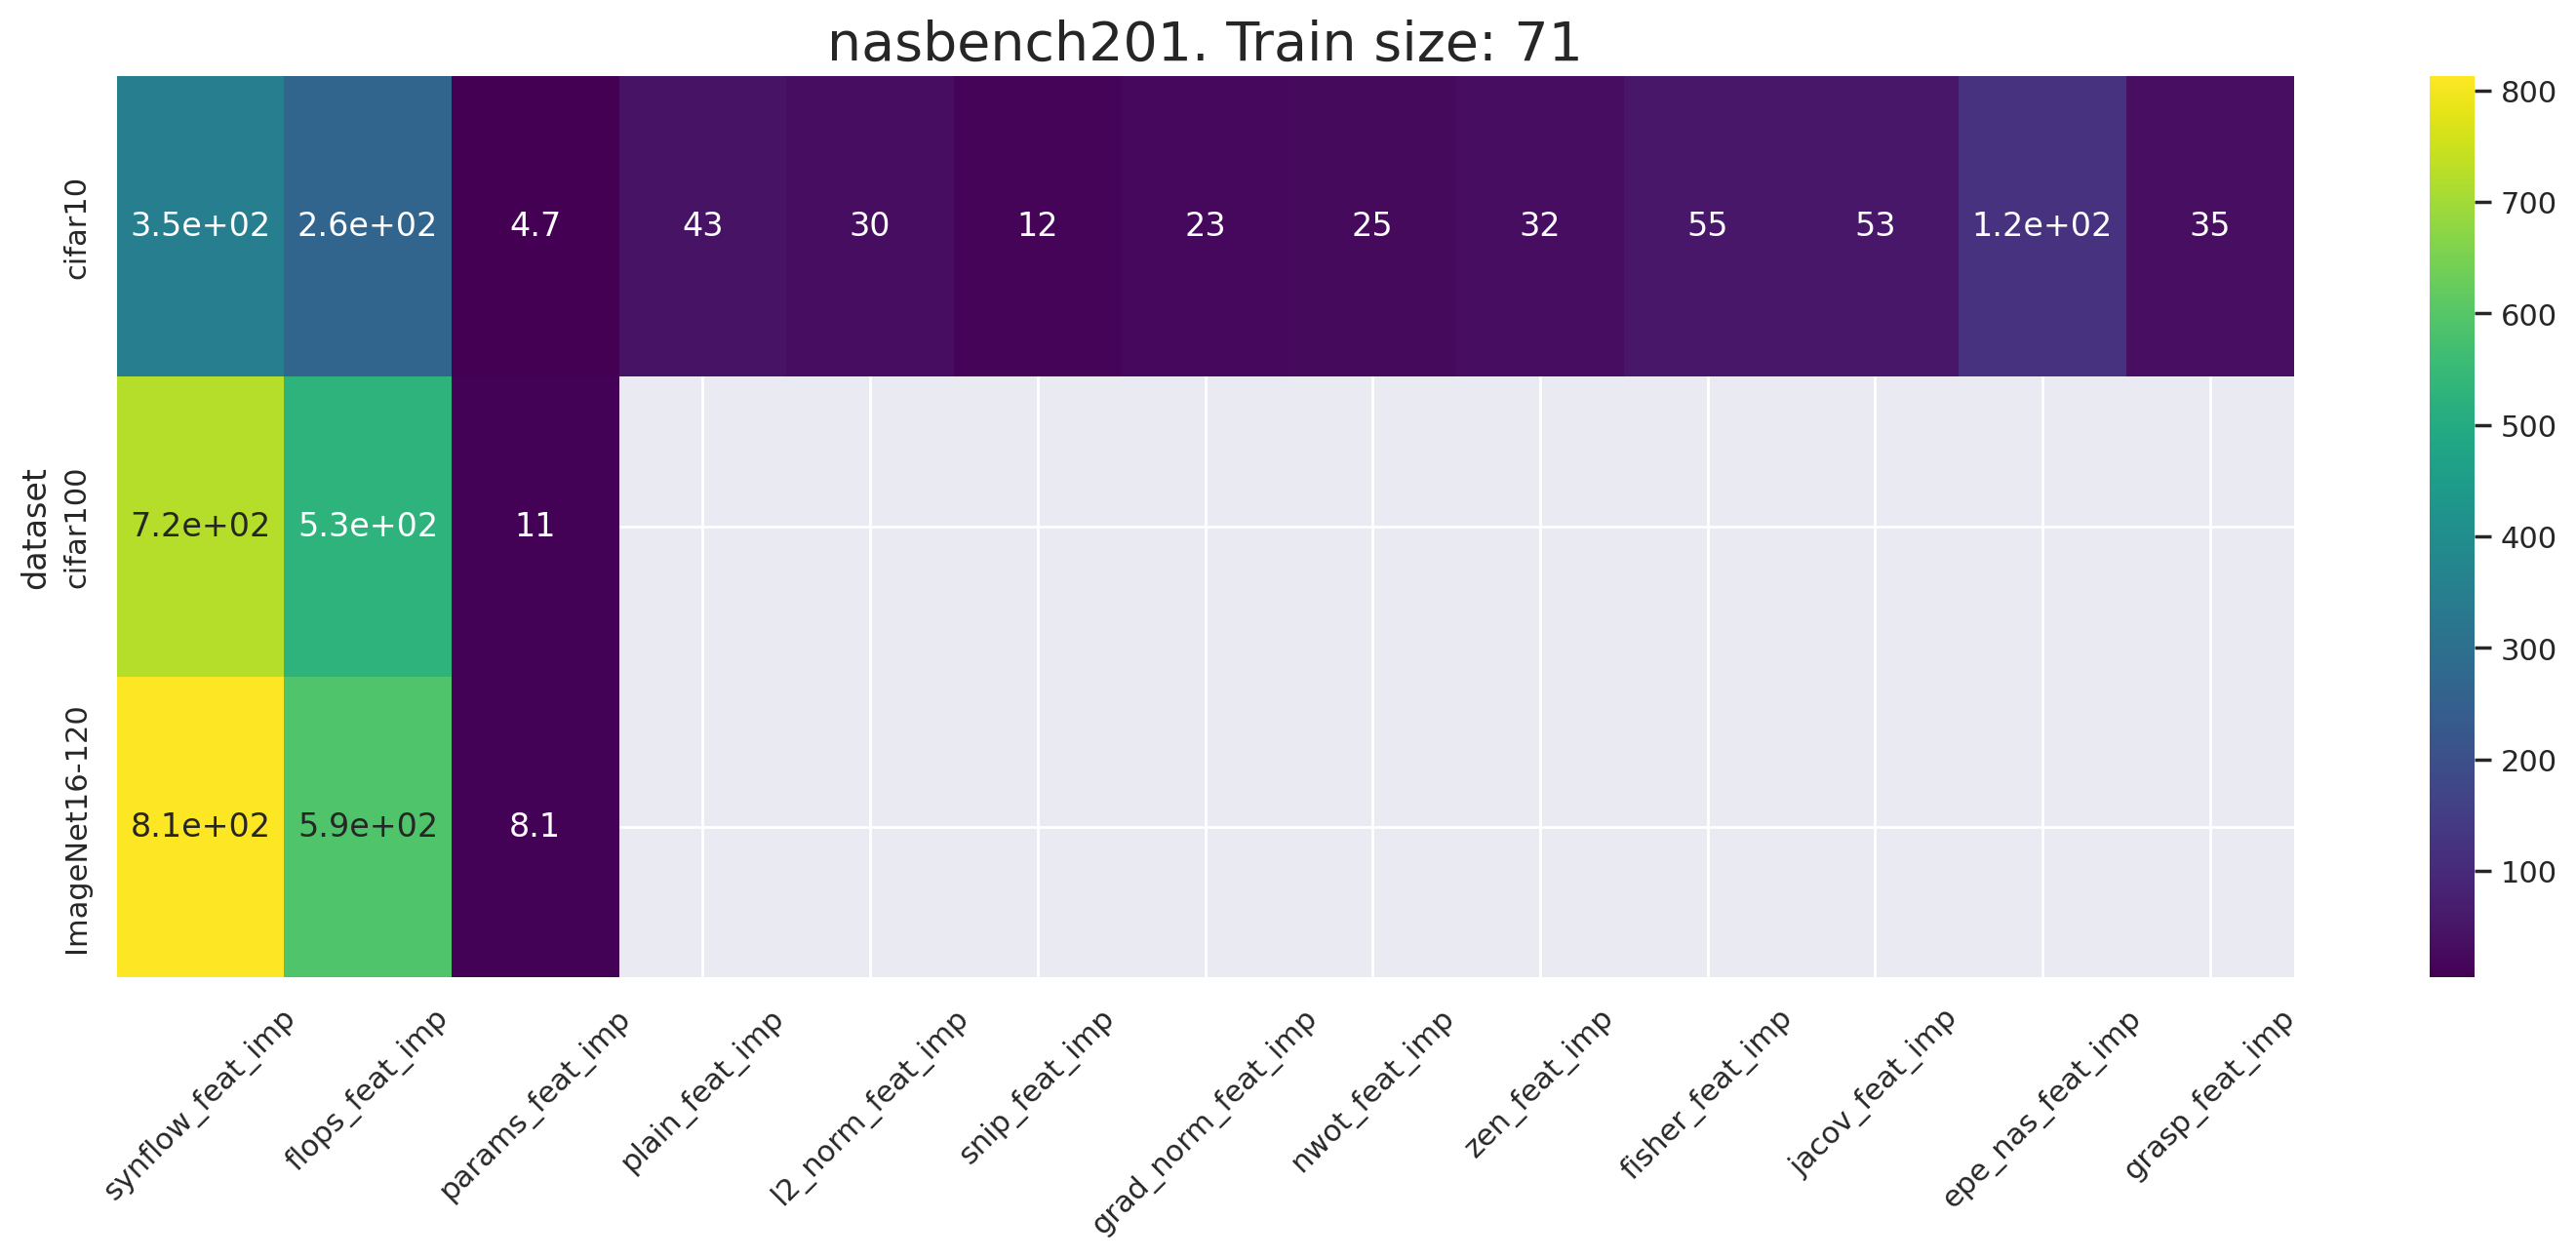

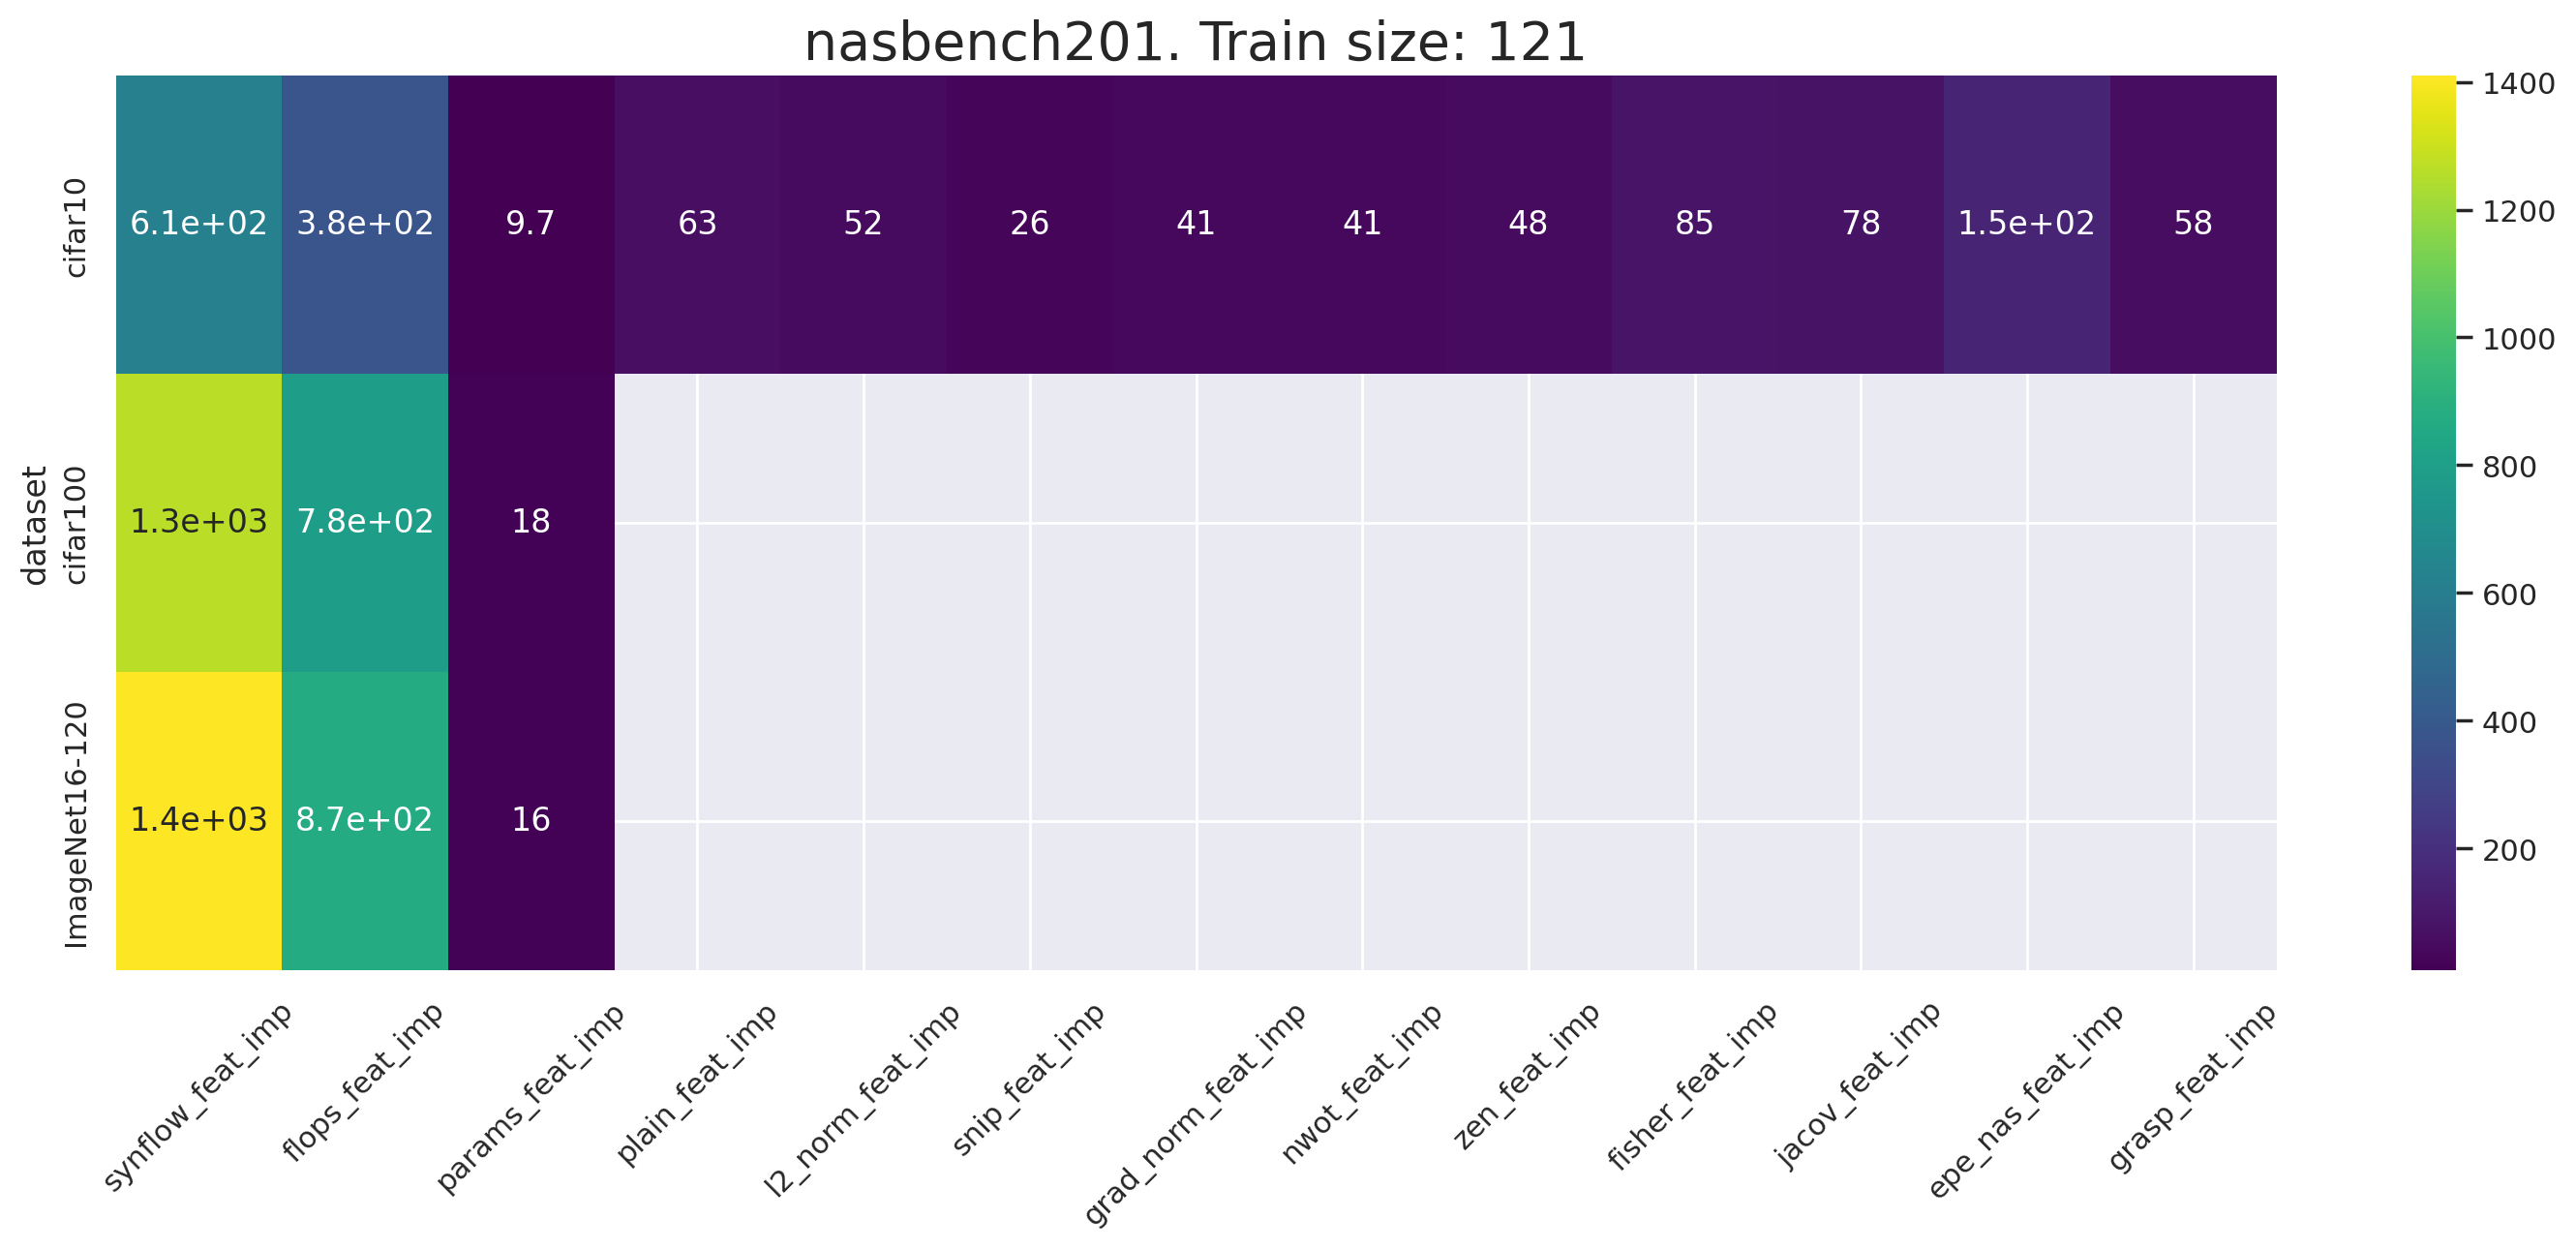

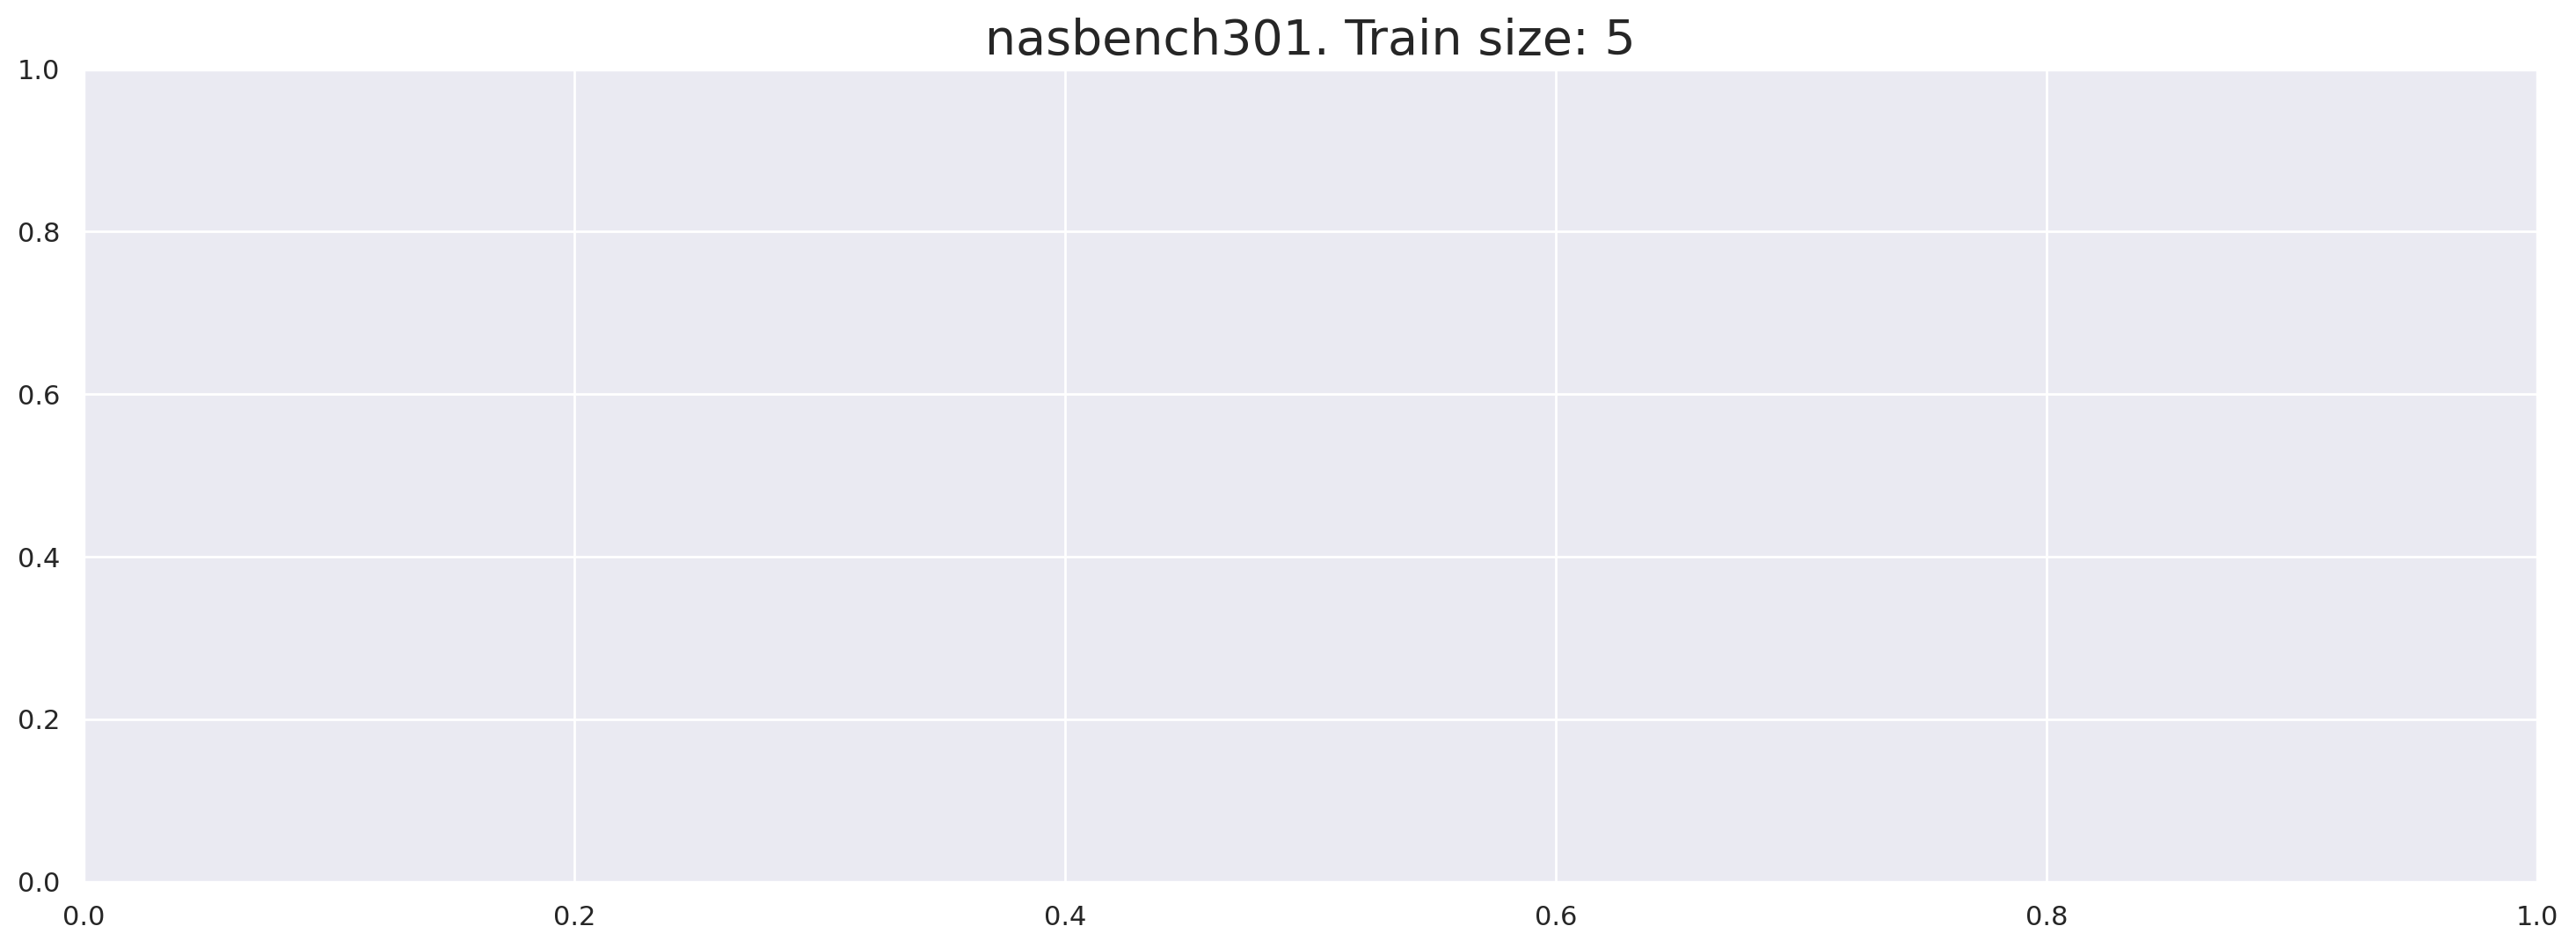

In [90]:
for search_space in BENCHMARKS.keys():
    for train_size in train_sizes:
        plot_feature_importance_heatmap(df, search_space, train_size=train_size)


In [ ]:
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes[:7], 'spearman', color='grey')